# nuScenes lidarseg and panoptic tutorial

## Setup
To install the nuScenes-lidarseg and/or Panoptic nuScenes expansion, download the dataset from https://www.nuscenes.org/download. Unpack the compressed file(s) into `/data/sets/nuscenes` and your folder structure should end up looking like this:
```
└── nuscenes  
    ├── Usual nuscenes folders (i.e. samples, sweep)
    │
    ├── lidarseg
    │   └── v1.0-{mini, test, trainval} <- Contains the .bin files; a .bin file
    │                                      contains the labels of the points in a
    │                                      point cloud (note that v1.0-test does not
    │                                      have any .bin files associated with it)
    │
    ├── panoptic
    │   └── v1.0-{mini, test, trainval} <- Contains the *_panoptic.npz files; a .npz file
    │                                      contains the panoptic labels of the points in a
    │                                      point cloud (note that v1.0-test does not
    │                                      have any .npz files associated with it)
    └── v1.0-{mini, test, trainval}
        ├── Usual files (e.g. attribute.json, calibrated_sensor.json etc.)
        ├── lidarseg.json  <- contains the mapping of each .bin file to the token
        ├── panoptic.json  <- contains the mapping of each .npz file to the token       
        └── category.json  <- contains the categories of the labels (note that the
                              category.json from nuScenes v1.0 is overwritten)
```

In [4]:
!wget https://www.nuscenes.org/data/v1.0-mini.tgz  # Download the nuScenes mini split.
!wget https://www.nuscenes.org/data/nuScenes-lidarseg-mini-v1.0.tar.bz2  # Download the nuScenes-lidarseg mini split.

--2023-10-08 20:48:39--  https://www.nuscenes.org/data/v1.0-mini.tgz
Resolving www.nuscenes.org (www.nuscenes.org)... 108.157.229.36, 108.157.229.80, 108.157.229.103, ...
Connecting to www.nuscenes.org (www.nuscenes.org)|108.157.229.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4167696325 (3.9G) [application/x-tar]
Saving to: ‘v1.0-mini.tgz’

v1.0-mini.tgz       100%[===================>]   3.88G  9.93MB/s    in 7m 29s  

2023-10-08 20:56:09 (8.85 MB/s) - ‘v1.0-mini.tgz’ saved [4167696325/4167696325]

--2023-10-08 20:56:09--  https://www.nuscenes.org/data/nuScenes-lidarseg-mini-v1.0.tar.bz2
Resolving www.nuscenes.org (www.nuscenes.org)... 108.157.229.103, 108.157.229.113, 108.157.229.36, ...
Connecting to www.nuscenes.org (www.nuscenes.org)|108.157.229.103|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1819477 (1.7M) [application/x-tar]
Saving to: ‘nuScenes-lidarseg-mini-v1.0.tar.bz2’

nuScenes-lidarseg-m 100%[==================

In [5]:
!tar -xf v1.0-mini.tgz -C dataset/  # Uncompress the nuScenes mini split.
!tar -xf nuScenes-lidarseg-mini-v1.0.tar.bz2 -C dataset/   # Uncompress the nuScenes-lidarseg mini split.

!pip install nuscenes-devkit &> /dev/null  # Install nuScenes.

## Initialization


In [25]:
%matplotlib inline

from nuscenes import NuScenes

nusc = NuScenes(version='v1.0-mini', dataroot='dataset/', verbose=True)

Loading NuScenes tables for version v1.0-mini...
Loading nuScenes-lidarseg...
32 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
404 lidarseg,
Done loading in 0.539 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


## Dataset analysis

This dataset contains data from autonomous vehicle, to be specific:
1. Data from all the sensors of the vehicle (including lidar data)
2. Segmentation for many classes, including pedastrians

Let's validate total amount of classes available in the given dataset

In [26]:
# nuscenes-lidarseg
categories_str = nusc.list_lidarseg_categories(sort_by='count')

Calculating semantic point stats for nuScenes-lidarseg...
  1  animal                                   nbr_points=           0
  7  human.pedestrian.stroller                nbr_points=           0
  8  human.pedestrian.wheelchair              nbr_points=           0
 19  vehicle.emergency.ambulance              nbr_points=           0
 20  vehicle.emergency.police                 nbr_points=           0
 10  movable_object.debris                    nbr_points=          48
  6  human.pedestrian.police_officer          nbr_points=          64
  3  human.pedestrian.child                   nbr_points=         230
  4  human.pedestrian.construction_worker     nbr_points=       1,412
 14  vehicle.bicycle                          nbr_points=       1,463
 11  movable_object.pushable_pullable         nbr_points=       2,293
  5  human.pedestrian.personal_mobility       nbr_points=       4,096
 13  static_object.bicycle_rack               nbr_points=       4,476
 12  movable_object.trafficcone 

We are interested in humans classes only.

## Sample examination



Let's pick a sample to use for this tutorial.

In [27]:
my_sample = nusc.sample[87]

## Get statistics of a lidarseg/panoptic sample token
Now let's take a look at what classes are present in the pointcloud of this particular sample.

In [28]:
# nuscenes-lidarseg
nusc.get_sample_lidarseg_stats(my_sample['token'], sort_by='count')

===== Statistics for 6dabc0fb1df045558f802246dd186b3f =====
 14  vehicle.bicycle                          n=           9
 11  movable_object.pushable_pullable         n=          11
  0  noise                                    n=          62
  2  human.pedestrian.adult                   n=          71
 16  vehicle.bus.rigid                        n=         105
  9  movable_object.barrier                   n=         280
 22  vehicle.trailer                          n=         302
 30  static.vegetation                        n=         330
 23  vehicle.truck                            n=       1,229
 26  flat.sidewalk                            n=       1,310
 25  flat.other                               n=       1,495
 17  vehicle.car                              n=       3,291
 28  static.manmade                           n=       4,650
 24  flat.driveable_surface                   n=       9,884
 31  vehicle.ego                              n=      11,723


By doing `sort_by='count'`, the classes and their respective frequency counts are printed in ascending order; you can also do `sort_by='name'` and `sort_by='index'` here as well.

## Render the lidarseg labels in the bird's eye view of a pointcloud
In the original nuScenes devkit, you would pass a sample data token into ```render_sample_data``` to render a bird's eye view of the pointcloud. However, the points would be colored according to the distance from the ego vehicle. Now with the extended nuScenes devkit, all you need to do is set ```show_lidarseg=True``` to visualize the class labels of the pointcloud.

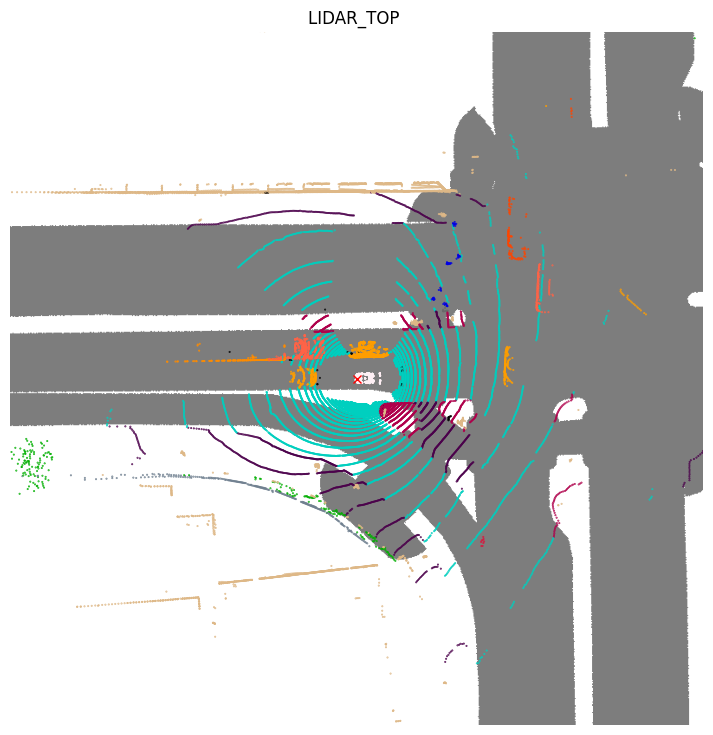

In [35]:
sample_data_token = my_sample['data']['LIDAR_TOP']
nusc.render_sample_data(sample_data_token,
                        with_anns=False,
                        show_lidarseg=True)

Unfortunately, this dataset contains only bird-view lidar data representation, which is not enough for our purposes. 